In [31]:
#Code for predicting housing prices
#Written by Lovisa Stenström 221101

### LOAD LIBRARIES###
library(dplyr)
library(tidyverse)
library(corrplot)

In [32]:
housing_data <- read.csv(file = "housing-data.csv",
                         stringsAsFactors = TRUE)

In [33]:
head(housing_data)

date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,views,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
2014-05-02 00:00:00,313000,3,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
2014-05-02 00:00:00,2384000,5,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2014-05-02 00:00:00,342000,3,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
2014-05-02 00:00:00,420000,3,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
2014-05-02 00:00:00,550000,4,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA
2014-05-02 00:00:00,490000,2,1.00,880,6380,1.0,0,0,3,880,0,1938,1994,522 NE 88th St,Seattle,WA 98115,USA


In [34]:
### DATA EXPLORATION ###

#First, let's have a quick look at the summary statistics of the dataset.
summary(housing_data)

                  date          price             bedrooms       bathrooms    
 2014-06-23 00:00:00: 142   Min.   :       0   Min.   :0.000   Min.   :0.000  
 2014-06-25 00:00:00: 131   1st Qu.:  322875   1st Qu.:3.000   1st Qu.:1.750  
 2014-06-26 00:00:00: 131   Median :  460943   Median :3.000   Median :2.250  
 2014-07-08 00:00:00: 127   Mean   :  551963   Mean   :3.401   Mean   :2.161  
 2014-07-09 00:00:00: 121   3rd Qu.:  654962   3rd Qu.:4.000   3rd Qu.:2.500  
 2014-06-24 00:00:00: 120   Max.   :26590000   Max.   :9.000   Max.   :8.000  
 (Other)            :3828                                                     
  sqft_living       sqft_lot           floors        waterfront      
 Min.   :  370   Min.   :    638   Min.   :1.000   Min.   :0.000000  
 1st Qu.: 1460   1st Qu.:   5001   1st Qu.:1.000   1st Qu.:0.000000  
 Median : 1980   Median :   7683   Median :1.500   Median :0.000000  
 Mean   : 2139   Mean   :  14852   Mean   :1.512   Mean   :0.007174  
 3rd Qu.: 2620   3

In [35]:
#We can for example see that some houses have been sold for 0$, we will remove those later.
#We also want to check NA values. 
anyNA(housing_data)

#There is no NA present in the data.

[1] FALSE

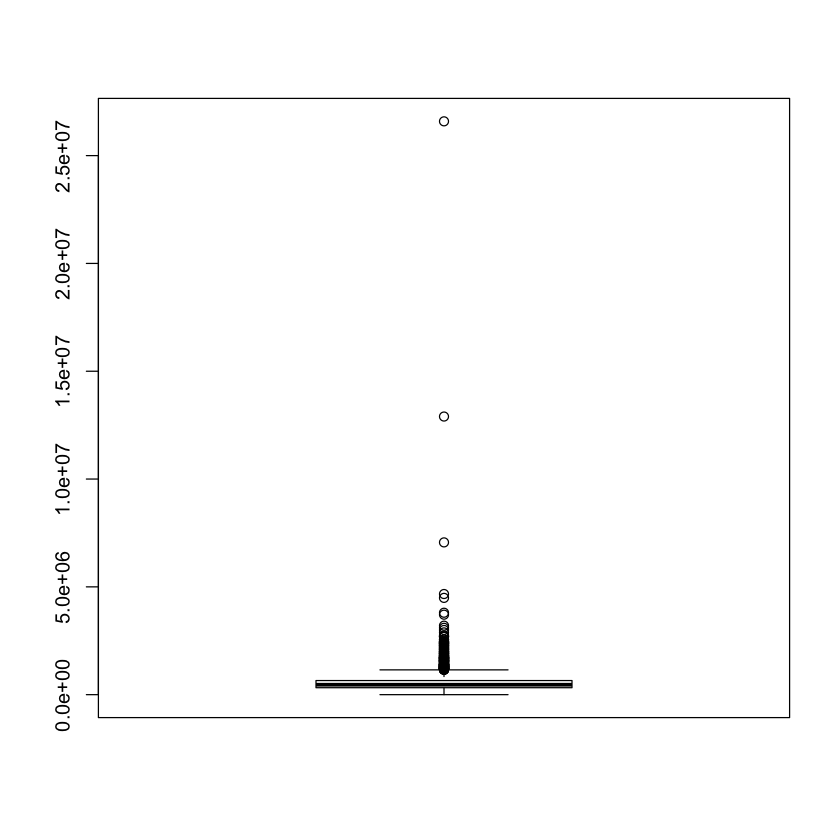

In [36]:
#We also want to check outliers.
boxplot(housing_data$price)

#There are some prices here that stand out from the rest,
#we will probably remove at least the top two later
#since these might confound the fitted regression line.

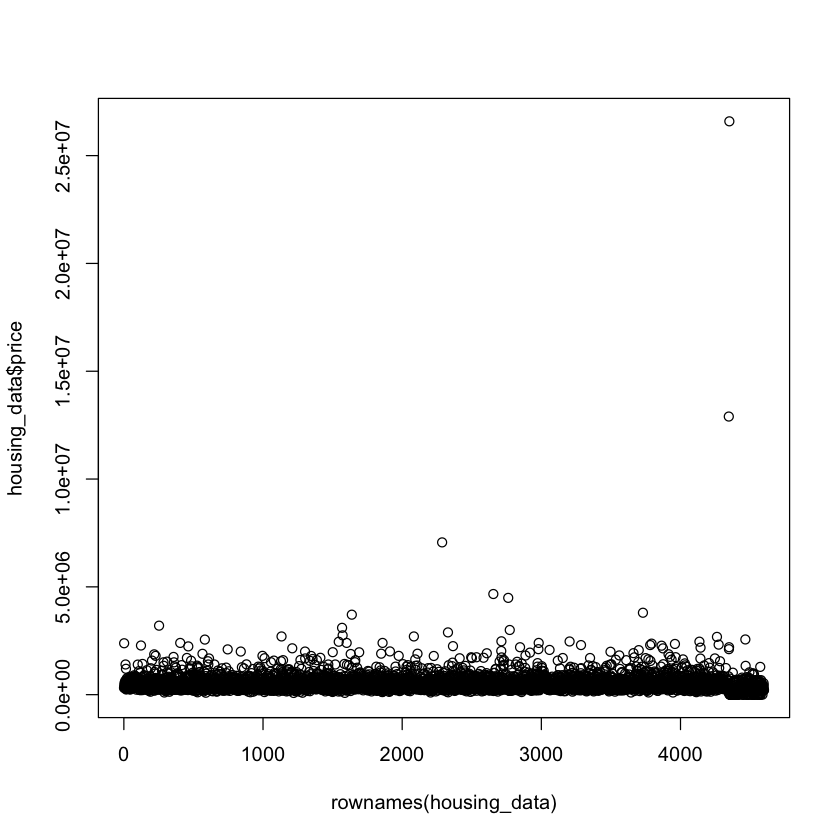

In [37]:
#Then, since we will predict housing prices,
#we want to make sure that there's no remarkable change of price over time in the dataset.
plot(rownames(housing_data),housing_data$price)

#This plot shows that it's not. It is only sold houses during a two month period here,
#so that makes sense.

In [38]:
### First feature selection ###

#After we quickly checked the quality of our data, we will start looking more closely into
#the variables. We can directly see that one variable isn't neccesary: Country.
#All houses are sold in the US. Therefore we can remove that feature. Since we also just
#concluded that time is not affecting the price for this dataset, we will exclude that as
#well.

#There are also three other features that describe the geographic position of the house in
#three different ways: street, city and statezip.
#For now, we will proceed only with the city feature, as it is more detailed than
#state zip code, but less detailed than street.

transformed_data <- select(housing_data, -c(date, country, street, statezip))

In [39]:
### DATA CLEAN-UP ###

#Now when we have the features we will start building our regression from,
#we need to transform the categorical variables into numerical.
transformed_data$city <- as.numeric(transformed_data$city)
length(unique(transformed_data$city))

[1] 44

In [40]:
#City now ranges from 1-44, which means that there are 44 different cities present in the
#dataset. Now our data frame consists of a mix of numericals and integers, so we will
#transform our data to only be numerical.
transformed_data <- mutate_all(transformed_data, function(x) as.numeric(x))

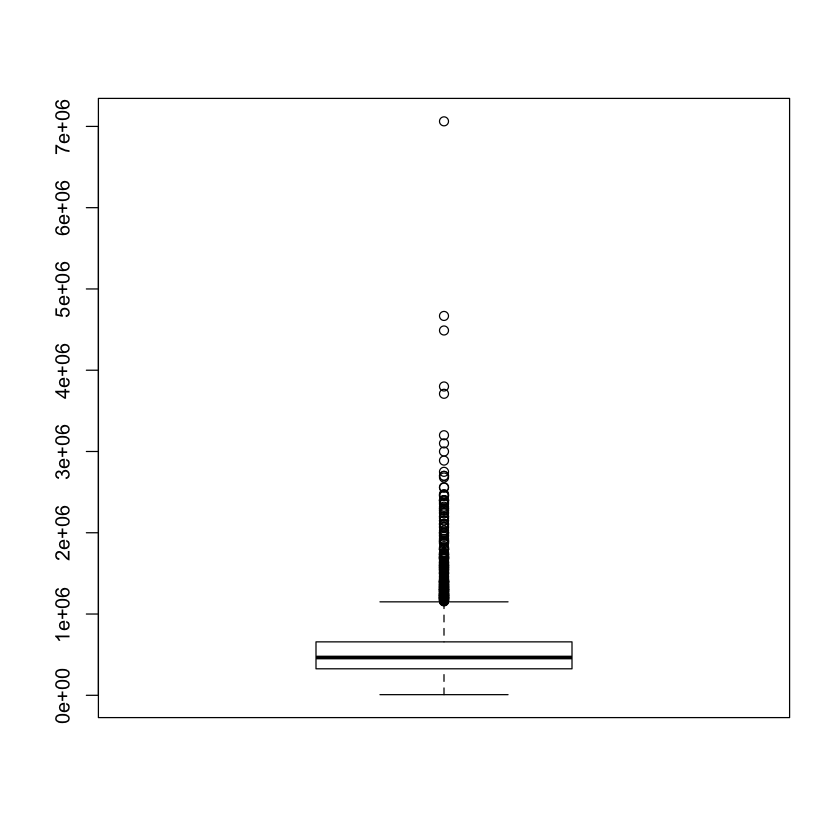

In [41]:
#We want to exclude the houses sold for 0$, so we remove those.
#We will also remove the two biggest outliers.
transformed_data <- transformed_data %>% filter(price != 0)
transformed_data <- transformed_data %>% arrange(desc(price))
transformed_data <- transformed_data[-c(1,2),]
boxplot(transformed_data$price)

#Now the boxplot looks a bit better.

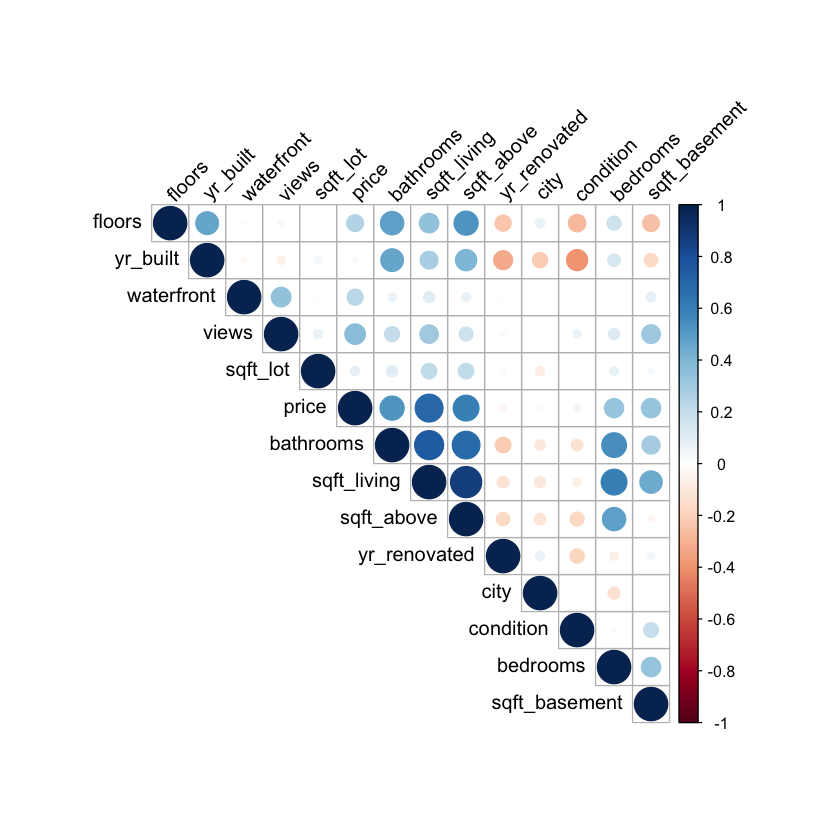

In [42]:
### SECOND FEATURE SELECTION ###

#We don't want to include features that highly correlate,
#so let's create a correlation matrix.
correlations <- cor(transformed_data)
corrplot(correlations, type = "upper", order = "hclust", 
         tl.col = "black", tl.srt = 45)

In [43]:
#We can see here that sqft living and sqft above are highly correlated,
#so we will not include sqft above.
transformed_data <- select(transformed_data, -sqft_above)

In [44]:
### TRAIN MODEL ###

#Now we can start training the first model.
#First, we need to split the data into training and test set.
#We will go for 80% in the training set, and 20% of the data in the test set.
#(Setting seed to get reproducible result)
set.seed(417)
idx <- sample(nrow(transformed_data), nrow(transformed_data)* 0.80)
housing_train <- transformed_data[idx,]
housing_test <- transformed_data[ -idx,]

In [45]:
#And now we will create our first simple linear regression to predict housing prices.
model_1 <- lm(price ~ bedrooms + bathrooms + sqft_living + sqft_lot + floors + waterfront
              + views + condition + sqft_basement + yr_built + yr_renovated + city,
              data = housing_train)
summary(model_1)

#The summary of the regression shows us that the R squared is only 0.57,
#which isn't a really impressive fit.
#Additionally, the year renovated seems to be poorly correlated with house prices.
#We don't even want to procceed with this model, so we will try to engineer the features
#a bit in the next section.



Call:
lm(formula = price ~ bedrooms + bathrooms + sqft_living + sqft_lot + 
    floors + waterfront + views + condition + sqft_basement + 
    yr_built + yr_renovated + city, data = housing_train)

Residuals:
     Min       1Q   Median       3Q      Max 
-1588692  -123181   -11146    95096  3752614 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)    4.760e+06  3.881e+05  12.267  < 2e-16 ***
bedrooms      -5.749e+04  5.884e+03  -9.771  < 2e-16 ***
bathrooms      5.647e+04  9.369e+03   6.027 1.84e-09 ***
sqft_living    2.823e+02  7.542e+00  37.433  < 2e-16 ***
sqft_lot      -6.775e-01  1.150e-01  -5.892 4.16e-09 ***
floors         4.463e+04  1.053e+04   4.240 2.29e-05 ***
waterfront     4.180e+05  5.244e+04   7.971 2.10e-15 ***
views          4.906e+04  6.051e+03   8.108 6.97e-16 ***
condition      2.953e+04  7.151e+03   4.130 3.71e-05 ***
sqft_basement -2.645e+01  1.200e+01  -2.205   0.0275 *  
yr_built      -2.514e+03  1.924e+02 -13.065  < 2e-16 ***

In [46]:
### FEATURE ENGINEERING ###

#Since the original features don't really fit a great line to the data,
#we will try to engineer the features to better predict housing prices.
#Everyone that bought a housing knows that there are at least two more relevant variables
#determining the price: how many houses that are available in the area and price/sqft.
#Let's try to add those features based on the data we have.

#Add availability as a metric based on number of houses sold in the area during 2 month
#(the time period included in the dataset).
transformed_data$availability <- sapply(transformed_data$city,
                                        function(x)
                                            length(which(transformed_data$city == x)))

In [47]:
#Let's split the new data into training and test set again, and then train our second model.
set.seed(417)
idx <- sample(nrow(transformed_data), nrow(transformed_data)* 0.80)
housing_train <- transformed_data[idx,]
housing_test <- transformed_data[ -idx,]


model_2 <- lm(price ~ bedrooms + bathrooms + sqft_living + sqft_lot + floors + waterfront +
            views + condition + sqft_basement + yr_built + yr_renovated + city +
            availability, data = housing_train)
summary(model_2)


Call:
lm(formula = price ~ bedrooms + bathrooms + sqft_living + sqft_lot + 
    floors + waterfront + views + condition + sqft_basement + 
    yr_built + yr_renovated + city + availability, data = housing_train)

Residuals:
     Min       1Q   Median       3Q      Max 
-1569601  -120255    -8397    98550  3643697 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)    2.817e+06  4.125e+05   6.830 9.89e-12 ***
bedrooms      -5.079e+04  5.794e+03  -8.766  < 2e-16 ***
bathrooms      4.735e+04  9.215e+03   5.138 2.92e-07 ***
sqft_living    3.070e+02  7.666e+00  40.049  < 2e-16 ***
sqft_lot      -4.854e-01  1.138e-01  -4.265 2.05e-05 ***
floors         3.567e+02  1.094e+04   0.033   0.9740    
waterfront     4.822e+05  5.167e+04   9.331  < 2e-16 ***
views          4.542e+04  5.939e+03   7.647 2.61e-14 ***
condition      3.644e+04  7.033e+03   5.182 2.31e-07 ***
sqft_basement -7.541e+01  1.243e+01  -6.068 1.43e-09 ***
yr_built      -1.531e+03  2.052e+02  -7.4

In [48]:
#We can see here that the availability seems to increase the fit a bit, but not much.
#Let's try with adding price/sqft.
transformed_data$price_p_sqft <- transformed_data$price/transformed_data$sqft_living
set.seed(417)
idx <- sample(nrow(transformed_data), nrow(transformed_data)* 0.80)
housing_train <- transformed_data[idx,]
housing_test <- transformed_data[ -idx,]

model_3 <- lm(price ~ bedrooms + bathrooms + sqft_living + sqft_lot + floors + waterfront +
                views + condition + sqft_basement + yr_built + yr_renovated + city +
                availability + price_p_sqft, data = housing_train)
summary(model_3)

#We can now see that the price/sqft drastically increase the fit to R squared = 0.88, which is much better than previously.
#It is also evident that most other features are not significant anymore when introducing the price/sqft variable.
#So those can probably be dropped without influencing model performance. However, we will move on and evaluate the predictions of our model now.


Call:
lm(formula = price ~ bedrooms + bathrooms + sqft_living + sqft_lot + 
    floors + waterfront + views + condition + sqft_basement + 
    yr_built + yr_renovated + city + availability + price_p_sqft, 
    data = housing_train)

Residuals:
     Min       1Q   Median       3Q      Max 
-1557964   -32261     8060    41598  3007713 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)    8.339e+04  2.296e+05   0.363 0.716500    
bedrooms      -3.951e+03  3.239e+03  -1.220 0.222634    
bathrooms      1.106e+04  5.101e+03   2.167 0.030262 *  
sqft_living    2.900e+02  4.235e+00  68.468  < 2e-16 ***
sqft_lot      -3.153e-01  6.284e-02  -5.017  5.5e-07 ***
floors        -5.529e+03  6.037e+03  -0.916 0.359847    
waterfront     2.508e+05  2.863e+04   8.759  < 2e-16 ***
views          5.002e+03  3.307e+03   1.512 0.130510    
condition      3.154e+03  3.898e+03   0.809 0.418470    
sqft_basement  4.483e+00  6.914e+00   0.648 0.516768    
yr_built      -3.436e

In [49]:
### EVALUATING MODEL ###

#Let's predict the prices on our test set.
housing_test$pred <- predict(model_3, housing_test)
predictions <- housing_test[,c(1,16)]
predictions$relative_error <- abs(housing_test$price - housing_test$pred)/housing_test$price
#This relative error won't translate well to the predictions under 0,
#but they are not so many.


In [50]:
#We can have a quick look at a few predictions.
predictions[1:20,]

,price,pred,relative_error
10,3000000,2365543,0.21148550
11,2888000,2624126,0.09136897
22,2400000,2160302,0.09987423
26,2384000,1812032,0.23991950
38,2180000,1715598,0.21302844
41,2110000,1686309,0.20080161
42,2110000,2049600,0.02862574
45,2065000,1643914,0.20391595
48,2000000,1945548,0.02722622
50,1990000,1617920,0.18697464


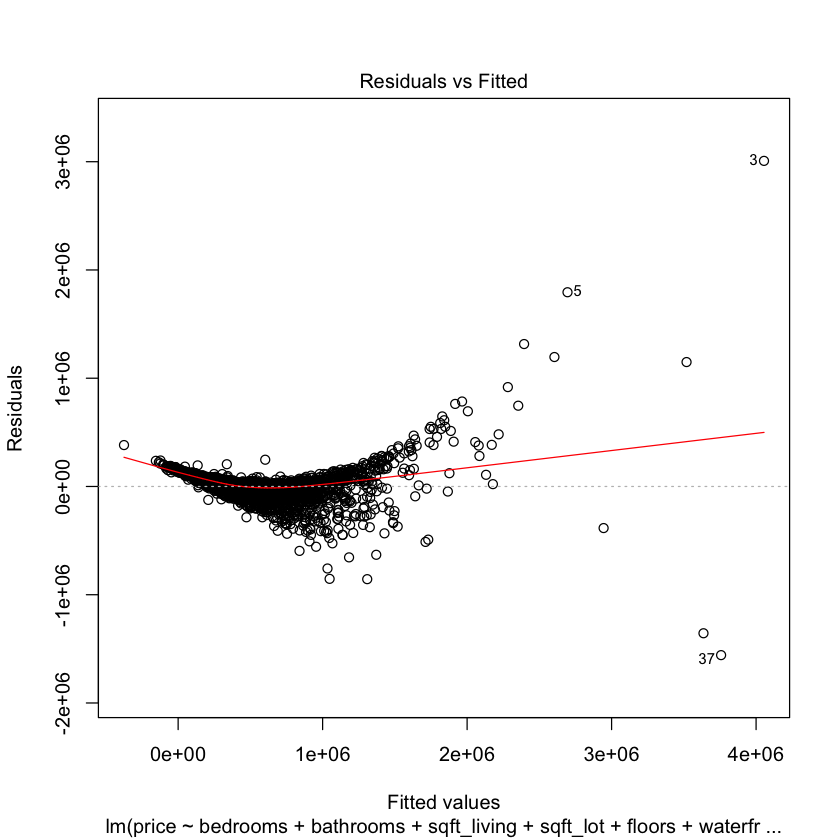

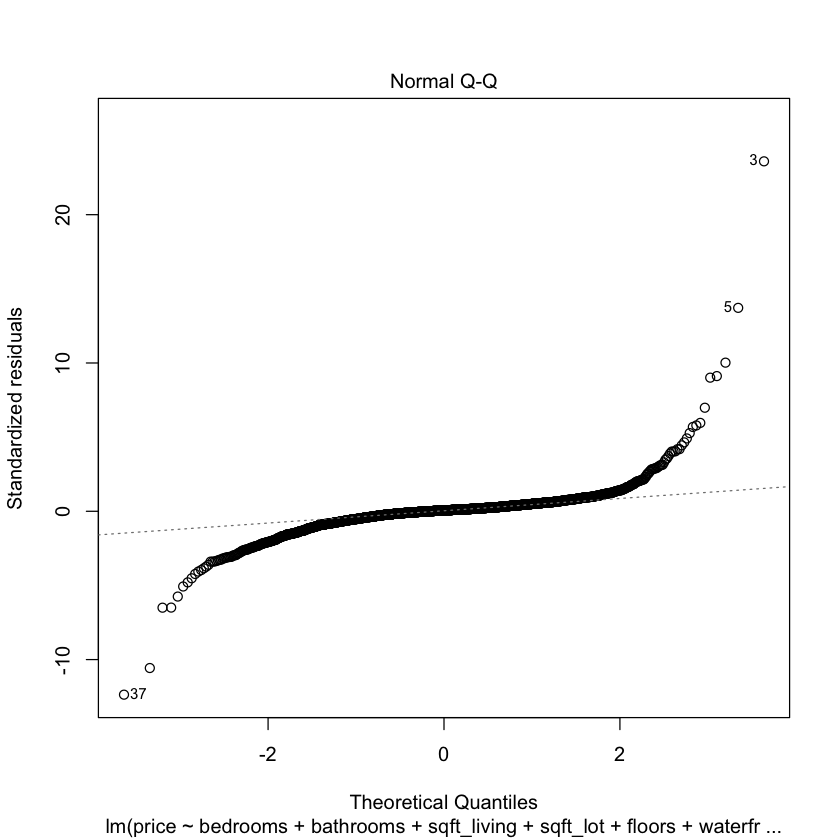

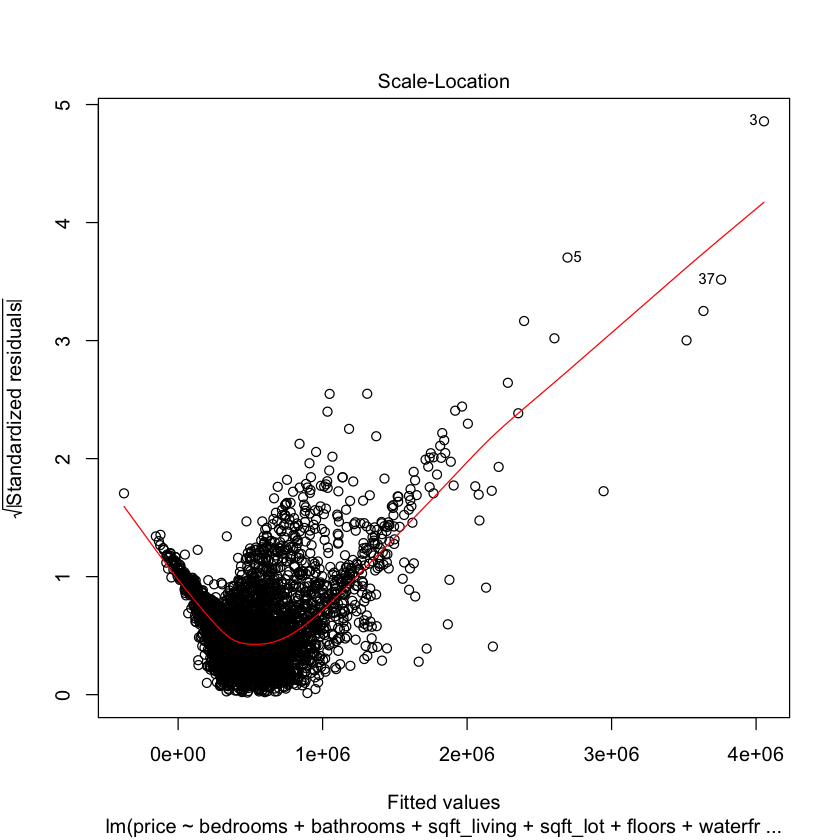

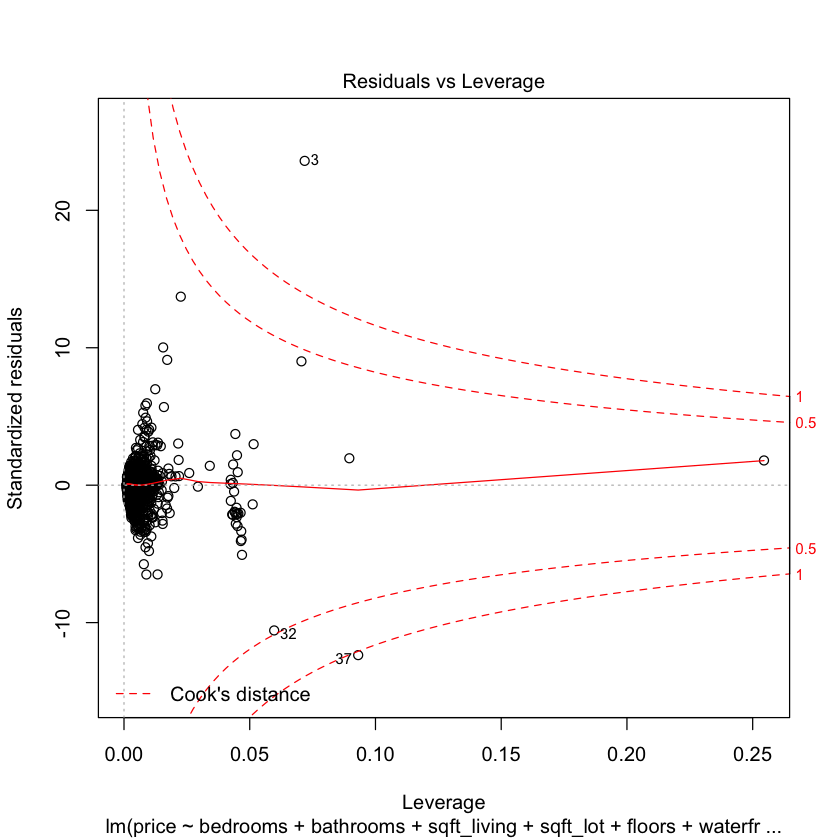

In [51]:
#And then we will make some visualizations of our predictions.
#How is the fit to the regression line?
plot(model_3)

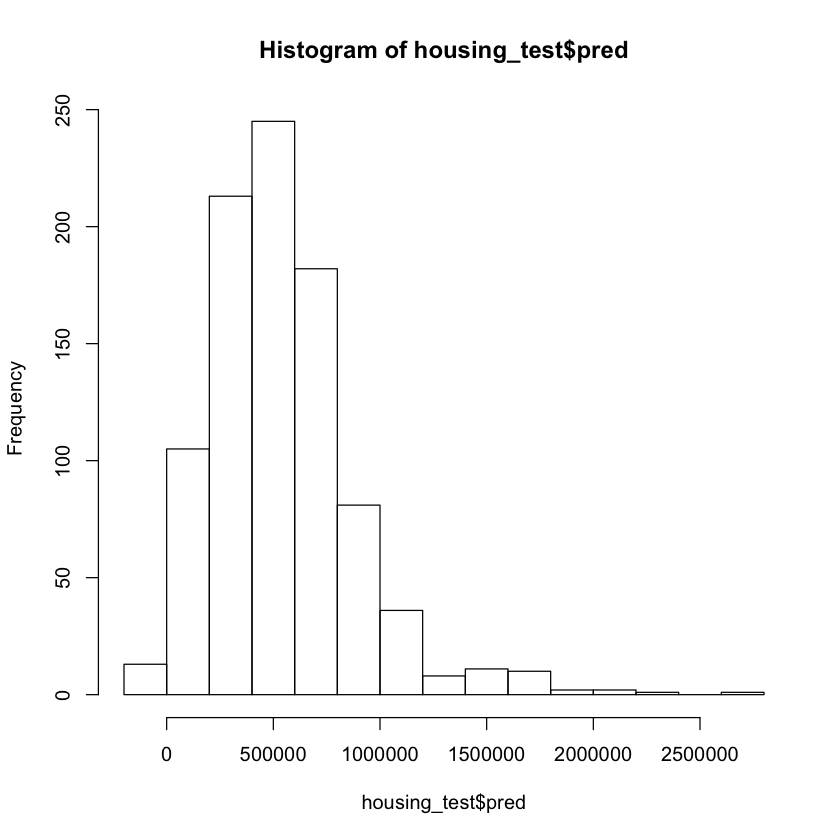

In [52]:
#How is the distribution of price predictions?
hist(housing_test$pred)

In [53]:
#We can directly spot one big flaw here in the predictions,
#some houses have been predicted to have a negative price value.
#This is obviously not possible but we will go ahead and estimate the error of our model
#using Root Mean Square Error anyway.
error_3 <- sqrt(mean((housing_test$price - housing_test$pred)^2))
print(error_3)

[1] 105340.4


In [54]:
#This is a fairly large error and there are for sure room for improvement in the model.
#If we try to predict the prices using our second model, is the error better or worse?
housing_test$pred <- predict(model_2, housing_test)
error_2 <- sqrt(mean((housing_test$price - housing_test$pred)^2))
print(error_2)

#The error is much bigger for our second model,
#meaning that the featues engineering at least improved our model.

[1] 208134.8


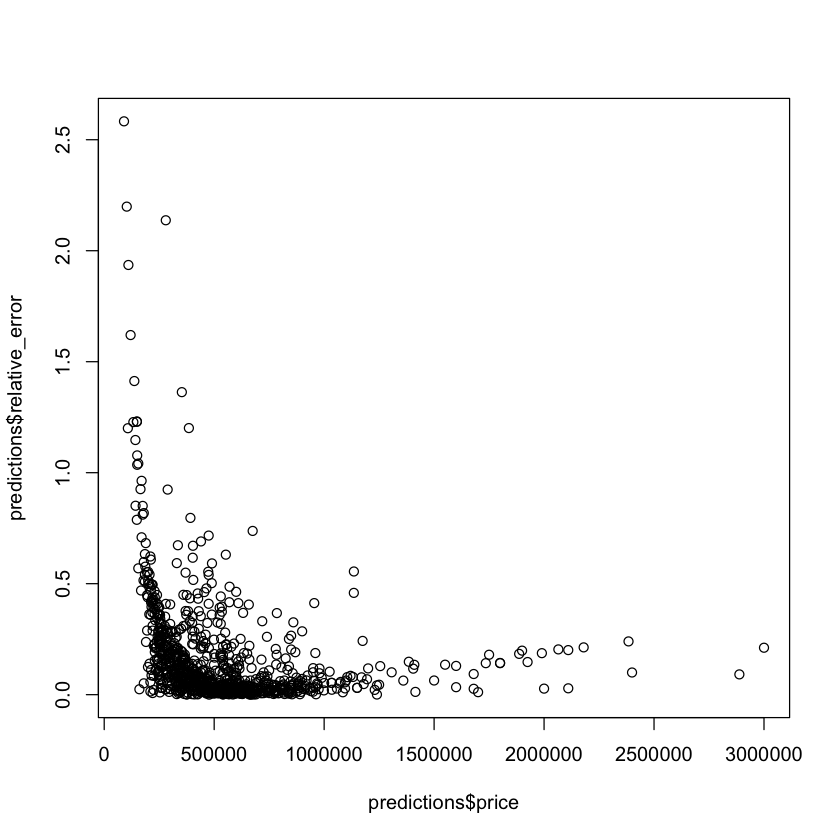

In [55]:
#Is there a relationship between real house price and relative error of the prediction?
plot(predictions$price, predictions$relative_error)

#Yes, it seems that the model has larger relative errors for the lower priced houses.

In [56]:
#### FUTURE IMPROVEMENTS ###

#Currently, we have a model that is fairy well fitted to the training data,
#but it performs quite bad, especially for lower priced houses.
#Maybe lower priced houses have been bought for less than asked price,
#and therefore the price doesn't follow what it is "supposed" to cost.
#But that is only speculation. Based on this result, it is aslo possible that the housing
#prices cannot really be predicted using a linear model, as prices might behave differently
#if they are cheap or expensive.

#There is still room for improvement in this model,
#one big is to get rid of negative predictions. If I had more time on building this model,
#I would probably look into possibilities of using other regression techniques,
#to ensure that a negative value cannot be predicted and explore non-linear fittings.

#When the model is good enough to not predict negative values,
#the error could also be computed using the Root Mean Square Logaritmic Error.
#This relative measure is more accurate in this case,
#as both lower and higher priced houses will contribute equally to the error,
#compared to measuring absolute error. However, it is not possible to compute that on
#negative values.

#Another thing is to look more into is to try to normalize or scale the features.
#This is something that is not included in this draft.

#Some features can probably also be removed since they don't contribute much to the
#predictions.

#Otherwise, I would also look more into engineering the existing features to make them
#more descriptive and better at predicting house prices.
#For example, mean housing prices in each city/area.

#And as a last remark, this model doesn't at all take price changes over time into account,
#as probably is the case on most markets.
#For that, more advanced algorithms like taking moving averages into account would be needed.
